In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import random, copy
from collections import deque
from datetime import datetime
import gym
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

In [2]:
SEED_VALUE = 1001
BUFFER_CAPACITY = 1000000
T_LR = 0.001
BUFFER_FILL_MATCH_COUNT = 256
BEST_MATCHES_COUNT = 8
VARIATION_RANGE = 2
GAMMA = 0.995
BATCH_SIZE = 128
RACE_COUNT = 10
NUM_MODEL = 10
NUM_EPOCH = 10
FINAL_RACE_COUNT = 500
RACE_PERCENT = 20
BEST_N = 2

In [3]:
plot_path = "plots/Trainee_Multiplier_Model_1001_CartPole/"

In [4]:
random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [5]:
# helper functions
def random_mul(val):
    '''
    gerates random number around 1
    val: deviation from 1
    '''
    return random.uniform(1 - val, 1 + val)

def max_two_index(l):
    m = sorted(l)
    n = m[-1]
    max_index_1 = [x for x in range(len(l)) if l[x] == n]
    o = [x for x in m if x != n]
    if len(o) == 0:
        return sorted(max_index_1)
    else:
        p = o[-1]
        max_index_2 = [x for x in range(len(l)) if l[x] == p]
        return sorted(max_index_1 + max_index_2)

def max_val_index(l):
    m = sorted(l)
    n = m[-1]
    max_index = [x for x in range(len(l)) if l[x] == n]
    return n, max_index[0]

def max_indices(l, length):
    m = list(set(l))
    n = sorted(m, reverse=True)
    o = min(length, len(n))
    p = n[:o]
    q = []
    for i in range(len(l)):
        for el in p:
            if el == l[i]:
                q.append(i)
    return sorted(list(set(q)))

def good_val_indices(l, percent, rank):
    m = max(l)
    n = min(l)
    o = m - (m - n) * (percent / 100)
    p1 = [i for i in range(len(l)) if l[i] == m]
    if len(p1) >= rank:
        return sorted(p1[:rank])
    q1 = [el for el in l if el != m]
    m1 = max(q1)
    p2 = [i for i in range(len(l)) if l[i] == m1][0]
    p = [i for i in range(len(l)) if o <= l[i] <= m]
    q = list(set(p).intersection(set([p2, p1[0]])))
    return sorted(q)

def biased_mean(l):
    if len(l) < 100:
        return 0
    else:
        return sum(l) / len(l)

def quad(x, r):
    return - 10 * ((x*x/(r+1))-x+1)

In [6]:
class Trainee:
    def __init__(self, state_dim):
        self.state_dim = state_dim
        self.model = self.nn_model()
        self.opt = tf.keras.optimizers.Adam(T_LR)

    def nn_model(self):
        inputs = Input((self.state_dim,))
        d1 = Dense(32, activation="relu")(inputs)
        d2 = Dense(32, activation="relu")(d1)
        outputs = Dense(1, activation="sigmoid")(d2)
        return tf.keras.Model(inputs, outputs)

    def get_action(self, state):
        state = np.array(state)
        predicted = self.model.predict(state)
        return 1 if predicted > 0.5 else 0

    def train(self, states, r_grads):
        r_grads = tf.convert_to_tensor(r_grads, dtype=tf.float32)
        with tf.GradientTape() as tape:
            x = self.model(states, training=True)
            grads = tape.gradient(x, self.model.trainable_variables, r_grads)
        self.opt.apply_gradients(zip(grads, self.model.trainable_variables))

In [7]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def store(self, info):
        self.buffer.append(info)

    def sample(self):
        sample = random.sample(self.buffer, BATCH_SIZE)
        states, r_grads = map(np.asarray, zip(*sample))
        states = np.array(states).reshape(BATCH_SIZE, -1)
        r_grads = np.array(r_grads).reshape(BATCH_SIZE, -1)
        return states, r_grads

    def size(self):
        return len(self.buffer)

In [8]:
class Agent:
    def __init__(self, env_name):
        self.env = gym.make(env_name)
        self.state_dim = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.n
        self.trs = [Trainee(self.state_dim) for _ in range(NUM_MODEL)]
        self.buffer = ReplayBuffer(BUFFER_CAPACITY)
        self.best_model = self.trs[0]

    def runners(self, model_list, weights, indices):
        delisted_indices = [i for i in range(NUM_MODEL) if i not in indices]
        for i in delisted_indices:
            updated_weights = [x * random_mul(VARIATION_RANGE) for x in weights]
            model_list[i].model.set_weights(updated_weights)
        return model_list

    def buffer_filler(self, best_model, index):
        temp_buffer_list = []
        ep_return_list = []
        for _ in range(BUFFER_FILL_MATCH_COUNT):
            ep_return = 0
            temp_buffer = []
            return_t = 0
            done = False
            state = self.env.reset()
            while not done:
                action = best_model.get_action([state])
                next_state, reward, done, _ = self.env.step(action)
                state = next_state
                ep_return += reward
                # r_grad = - (reward + (1 - GAMMA) * return_t) / (return_t + 0.1)
                x = reward + (1 - GAMMA) * return_t
                r_grad = quad(x, return_t)
                return_t = reward + GAMMA * return_t
                temp_buffer.append([state, r_grad])
            ep_return_list.append(ep_return)
            temp_buffer_list.append(temp_buffer)
        imp_index = max_indices(ep_return_list, BEST_MATCHES_COUNT)
        num_stored = 0
        for i in imp_index:
            for x in temp_buffer_list[i]:
                num_stored += 1
                self.buffer.store(x)
        for_plot = [ep_return_list[i] for i in imp_index]
        plt.plot(for_plot)
        plt.title(f"Buffer input Returns of race {index} with injection {num_stored}")
        plt.savefig(plot_path + f"buffer_returns_{index}.png")
        plt.show()
        
    def train_from_buffer(self, model_list):
        for m in model_list:
            for _ in range(NUM_EPOCH):
                states, r_grads = self.buffer.sample()
                m.train(states, r_grads)
    
    def race(self, model_list, index):
        race_avg = [0] * NUM_MODEL
        for i in range(NUM_MODEL):
            reward_sum = 0
            for _ in range(RACE_COUNT):
                done = False
                state = self.env.reset()
                while not done:
                    action = model_list[i].get_action([state])
                    next_state, reward, done, _ = self.env.step(action)
                    state = next_state
                    reward_sum += reward
            race_avg[i] = reward_sum / RACE_COUNT
        plt.plot(race_avg)
        plt.title(f"Racer Returns of race {index}")
        plt.savefig(plot_path + f"race_avg_returns_{index}.png")
        plt.show()
        return race_avg

    def train(self):
        i = 0
        for_plot = []
        ma = []
        model_list = self.trs
        while i < FINAL_RACE_COUNT and biased_mean(ma) < 200:
            print(f"Starting filling buffer: {i}...")
            self.buffer_filler(self.best_model, i)
            print("Training starts...")
            self.train_from_buffer(model_list)
            print(f"Buufer size: {self.buffer.size()}, Starting race {i}")
            race_avg = self.race(model_list, i)
            print("Race complete!")
            max_ep_reward, best_model_index = max_val_index(race_avg)
            good_model_indices = good_val_indices(race_avg, RACE_PERCENT, BEST_N)
            self.best_model = self.trs[best_model_index]
            for_plot.append(max_ep_reward)
            ma = for_plot[-(len(for_plot) if len(for_plot) < 100 else 100):]
            print(f"At race {i}, finalist model is Model#({best_model_index}) with episode reward {max_ep_reward}")
            print(f"carrying following Model numbers: {good_model_indices}")
            new_weights = model_list[best_model_index].model.get_weights()
            model_list = self.runners(model_list, new_weights, good_model_indices)
            i += 1
        plt.plot(for_plot)
        plt.title("Final Return Plot")
        plt.savefig(plot_path + "Final_Returns.png")
        plt.show()
        
    def get_final_weights(self):
        return self.best_model.model.get_weights()

Starts at 21-12-10, 09:16:07
Starting filling buffer: 0...


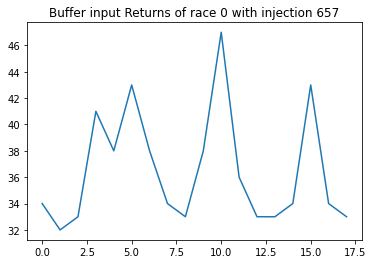

Training starts...
Buufer size: 657, Starting race 0


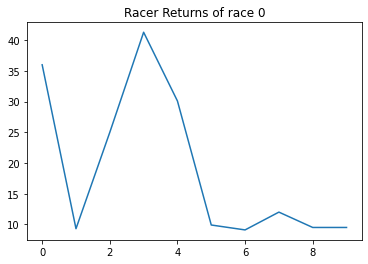

Race complete!
At race 0, finalist model is Model#(3) with episode reward 41.3
carrying following Model numbers: [0, 3]
Starting filling buffer: 1...


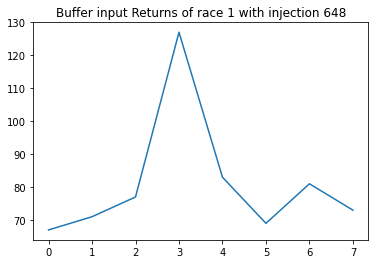

Training starts...
Buufer size: 1305, Starting race 1


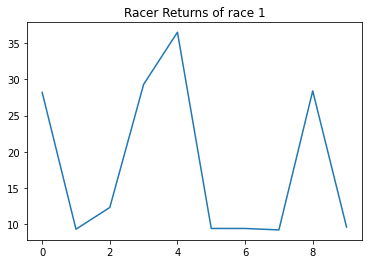

Race complete!
At race 1, finalist model is Model#(4) with episode reward 36.5
carrying following Model numbers: [4]
Starting filling buffer: 2...


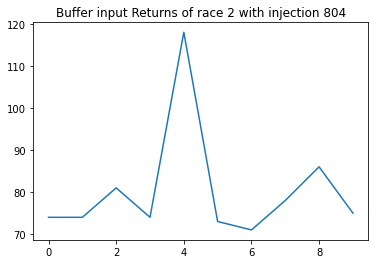

Training starts...
Buufer size: 2109, Starting race 2


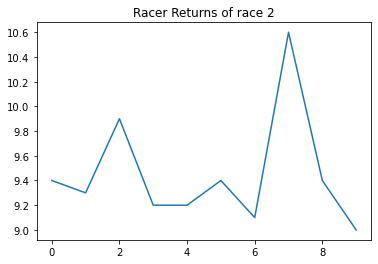

Race complete!
At race 2, finalist model is Model#(7) with episode reward 10.6
carrying following Model numbers: [7]
Starting filling buffer: 3...


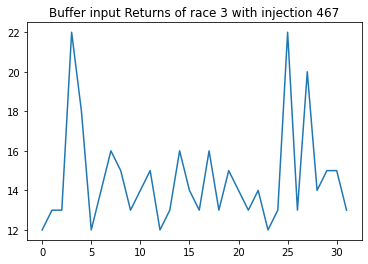

Training starts...
Buufer size: 2576, Starting race 3


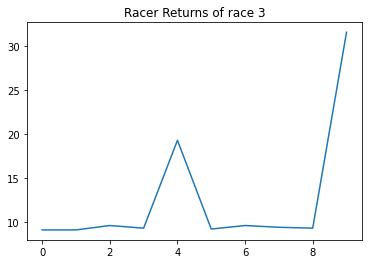

Race complete!
At race 3, finalist model is Model#(9) with episode reward 31.6
carrying following Model numbers: [9]
Starting filling buffer: 4...


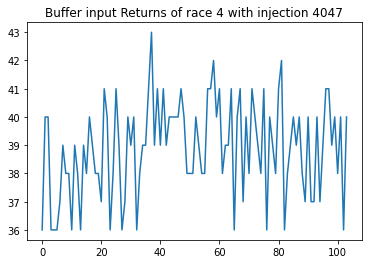

Training starts...
Buufer size: 6623, Starting race 4


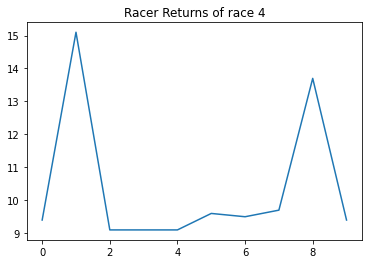

Race complete!
At race 4, finalist model is Model#(1) with episode reward 15.1
carrying following Model numbers: [1]
Starting filling buffer: 5...


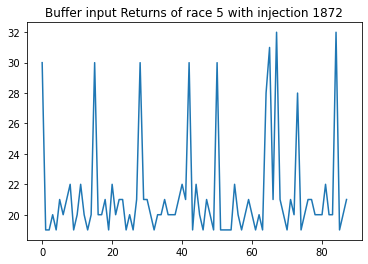

Training starts...
Buufer size: 8495, Starting race 5


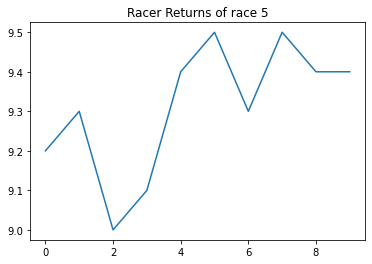

Race complete!
At race 5, finalist model is Model#(5) with episode reward 9.5
carrying following Model numbers: [5, 7]
Starting filling buffer: 6...


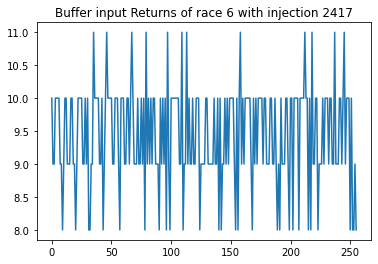

Training starts...
Buufer size: 10912, Starting race 6


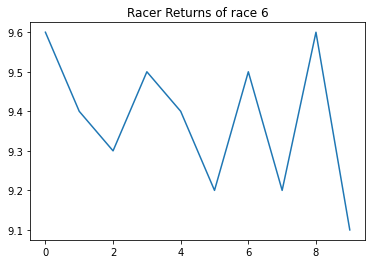

Race complete!
At race 6, finalist model is Model#(0) with episode reward 9.6
carrying following Model numbers: [0, 8]
Starting filling buffer: 7...


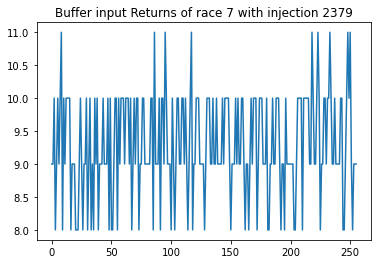

Training starts...
Buufer size: 13291, Starting race 7


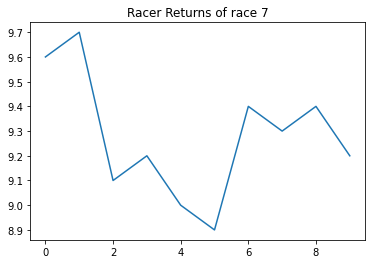

Race complete!
At race 7, finalist model is Model#(1) with episode reward 9.7
carrying following Model numbers: [0, 1]
Starting filling buffer: 8...


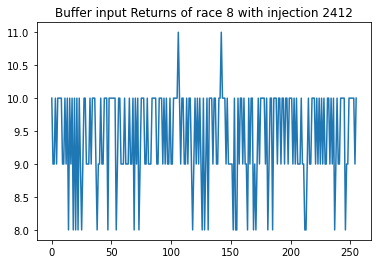

Training starts...
Buufer size: 15703, Starting race 8


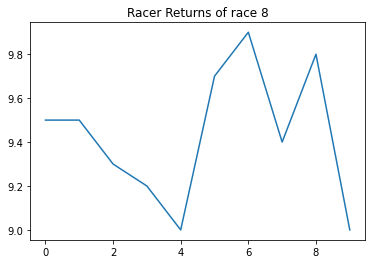

Race complete!
At race 8, finalist model is Model#(6) with episode reward 9.9
carrying following Model numbers: [6, 8]
Starting filling buffer: 9...


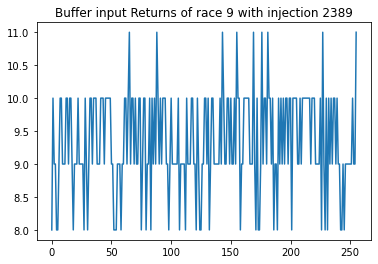

Training starts...
Buufer size: 18092, Starting race 9


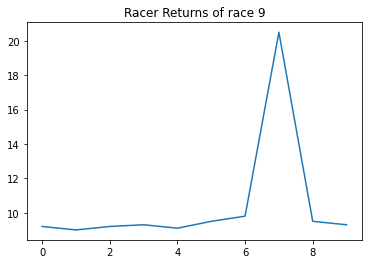

Race complete!
At race 9, finalist model is Model#(7) with episode reward 20.5
carrying following Model numbers: [7]
Starting filling buffer: 10...


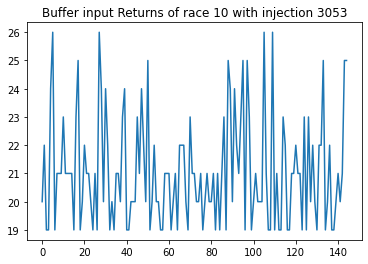

Training starts...
Buufer size: 21145, Starting race 10


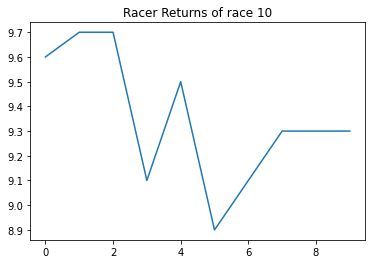

Race complete!
At race 10, finalist model is Model#(1) with episode reward 9.7
carrying following Model numbers: [1, 2]
Starting filling buffer: 11...


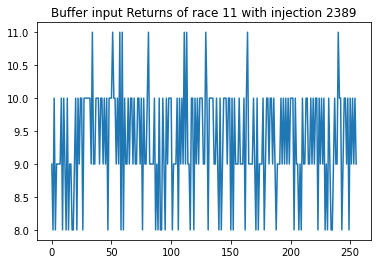

Training starts...
Buufer size: 23534, Starting race 11


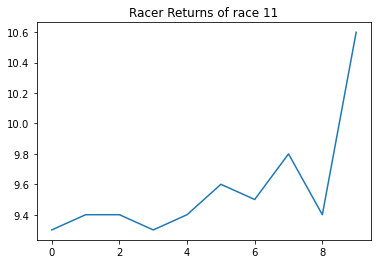

Race complete!
At race 11, finalist model is Model#(9) with episode reward 10.6
carrying following Model numbers: [9]
Starting filling buffer: 12...


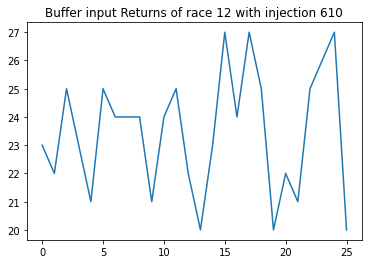

Training starts...
Buufer size: 24144, Starting race 12


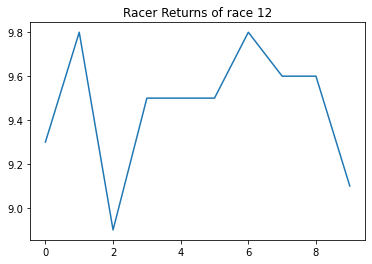

Race complete!
At race 12, finalist model is Model#(1) with episode reward 9.8
carrying following Model numbers: [1, 6]
Starting filling buffer: 13...


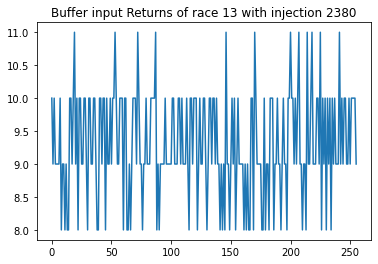

Training starts...
Buufer size: 26524, Starting race 13


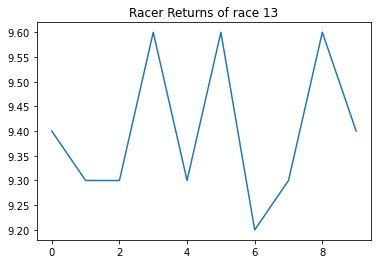

Race complete!
At race 13, finalist model is Model#(3) with episode reward 9.6
carrying following Model numbers: [3, 5]
Starting filling buffer: 14...


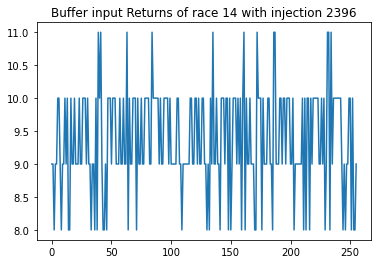

Training starts...
Buufer size: 28920, Starting race 14


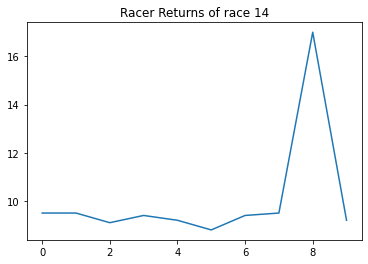

Race complete!
At race 14, finalist model is Model#(8) with episode reward 17.0
carrying following Model numbers: [8]
Starting filling buffer: 15...


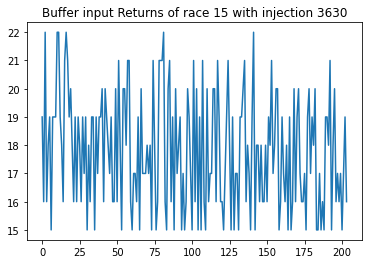

Training starts...
Buufer size: 32550, Starting race 15


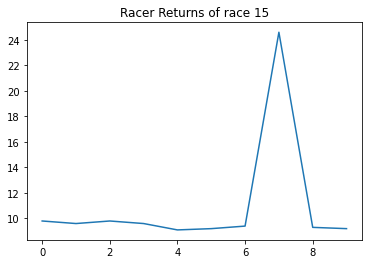

Race complete!
At race 15, finalist model is Model#(7) with episode reward 24.6
carrying following Model numbers: [7]
Starting filling buffer: 16...


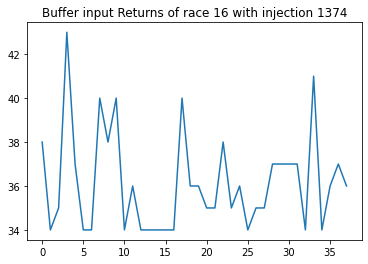

Training starts...
Buufer size: 33924, Starting race 16


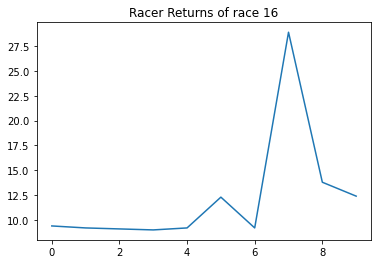

Race complete!
At race 16, finalist model is Model#(7) with episode reward 28.9
carrying following Model numbers: [7]
Starting filling buffer: 17...


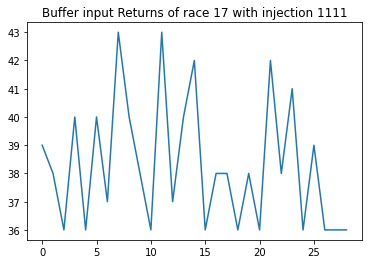

Training starts...
Buufer size: 35035, Starting race 17


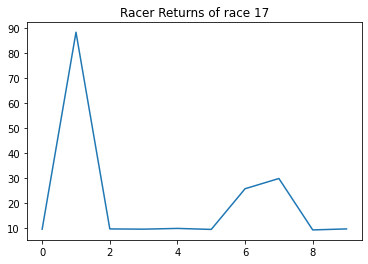

Race complete!
At race 17, finalist model is Model#(1) with episode reward 88.3
carrying following Model numbers: [1]
Starting filling buffer: 18...


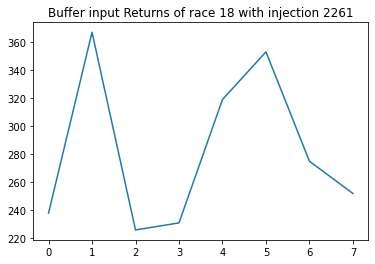

Training starts...
Buufer size: 37296, Starting race 18


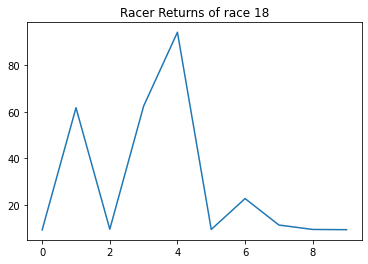

Race complete!
At race 18, finalist model is Model#(4) with episode reward 94.3
carrying following Model numbers: [4]
Starting filling buffer: 19...


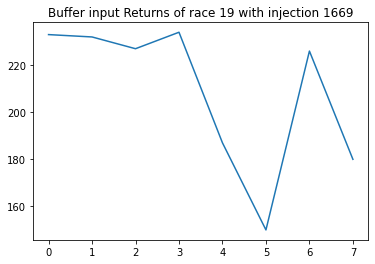

Training starts...
Buufer size: 38965, Starting race 19


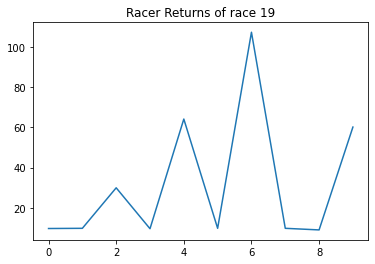

Race complete!
At race 19, finalist model is Model#(6) with episode reward 107.5
carrying following Model numbers: [6]
Starting filling buffer: 20...


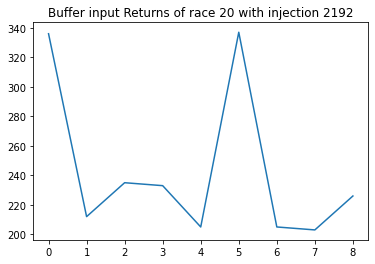

Training starts...
Buufer size: 41157, Starting race 20


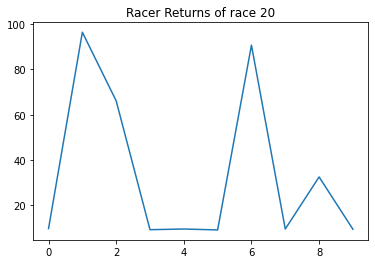

Race complete!
At race 20, finalist model is Model#(1) with episode reward 96.4
carrying following Model numbers: [1, 6]
Starting filling buffer: 21...


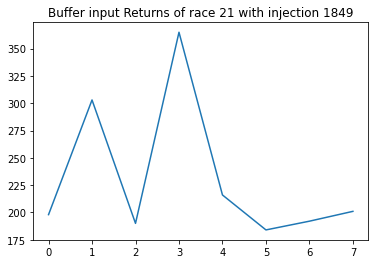

Training starts...
Buufer size: 43006, Starting race 21


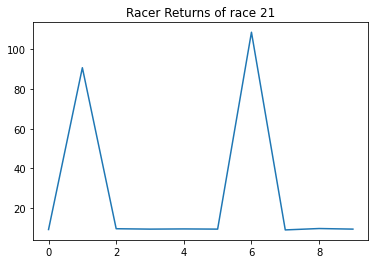

Race complete!
At race 21, finalist model is Model#(6) with episode reward 108.7
carrying following Model numbers: [1, 6]
Starting filling buffer: 22...


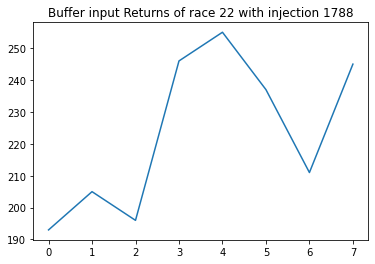

Training starts...
Buufer size: 44794, Starting race 22


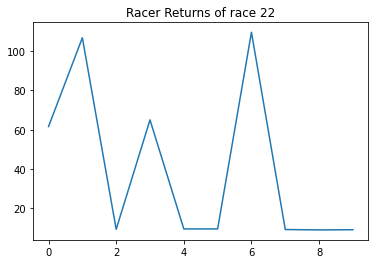

Race complete!
At race 22, finalist model is Model#(6) with episode reward 109.5
carrying following Model numbers: [1, 6]
Starting filling buffer: 23...


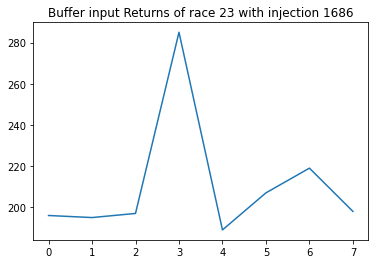

Training starts...
Buufer size: 46480, Starting race 23


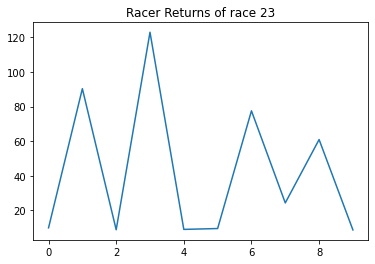

Race complete!
At race 23, finalist model is Model#(3) with episode reward 122.9
carrying following Model numbers: [3]
Starting filling buffer: 24...


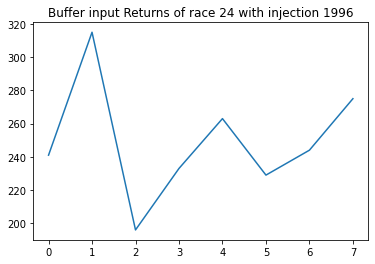

Training starts...
Buufer size: 48476, Starting race 24


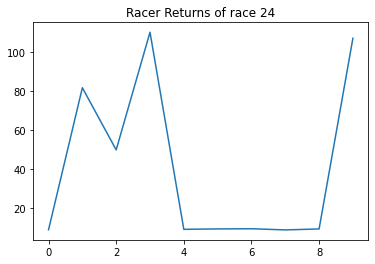

Race complete!
At race 24, finalist model is Model#(3) with episode reward 110.3
carrying following Model numbers: [3, 9]
Starting filling buffer: 25...


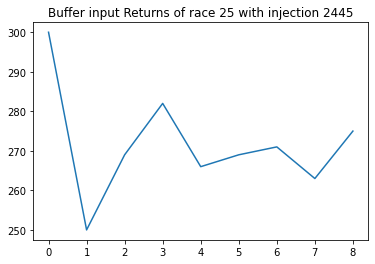

Training starts...
Buufer size: 50921, Starting race 25


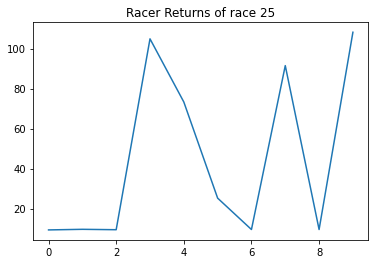

Race complete!
At race 25, finalist model is Model#(9) with episode reward 108.2
carrying following Model numbers: [3, 9]
Starting filling buffer: 26...


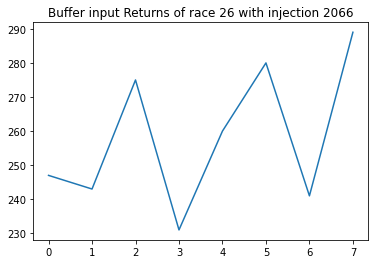

Training starts...
Buufer size: 52987, Starting race 26


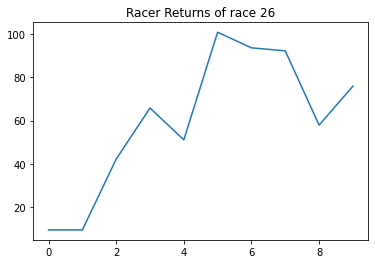

Race complete!
At race 26, finalist model is Model#(5) with episode reward 100.8
carrying following Model numbers: [5, 6]
Starting filling buffer: 27...


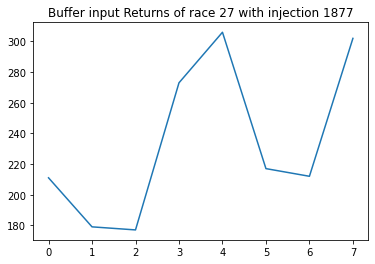

Training starts...
Buufer size: 54864, Starting race 27


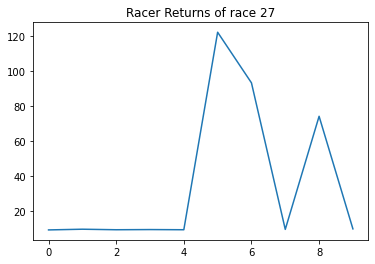

Race complete!
At race 27, finalist model is Model#(5) with episode reward 122.1
carrying following Model numbers: [5]
Starting filling buffer: 28...


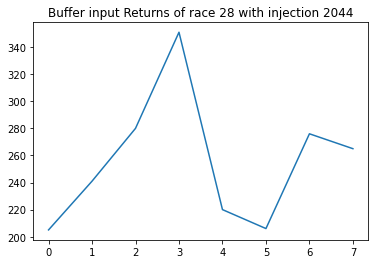

Training starts...
Buufer size: 56908, Starting race 28


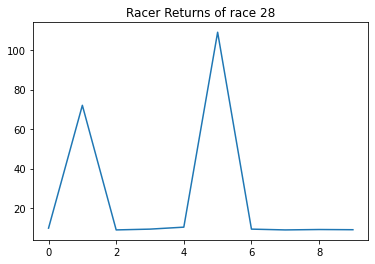

Race complete!
At race 28, finalist model is Model#(5) with episode reward 109.0
carrying following Model numbers: [5]
Starting filling buffer: 29...


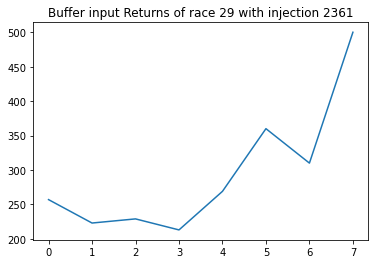

Training starts...
Buufer size: 59269, Starting race 29


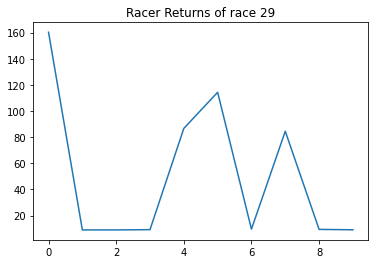

Race complete!
At race 29, finalist model is Model#(0) with episode reward 160.2
carrying following Model numbers: [0]
Starting filling buffer: 30...


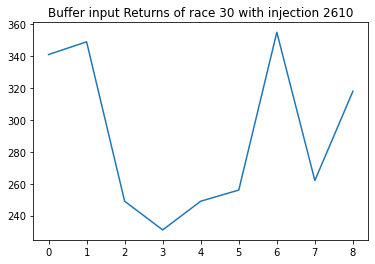

Training starts...
Buufer size: 61879, Starting race 30


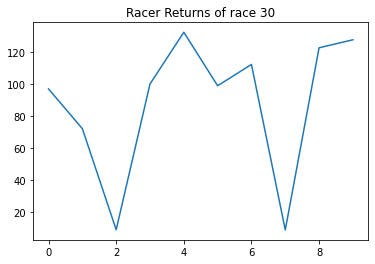

Race complete!
At race 30, finalist model is Model#(4) with episode reward 132.5
carrying following Model numbers: [4, 9]
Starting filling buffer: 31...


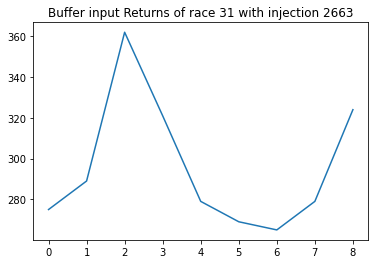

Training starts...
Buufer size: 64542, Starting race 31


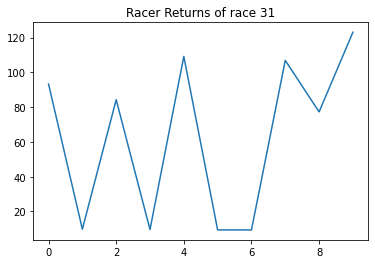

Race complete!
At race 31, finalist model is Model#(9) with episode reward 123.1
carrying following Model numbers: [4, 9]
Starting filling buffer: 32...


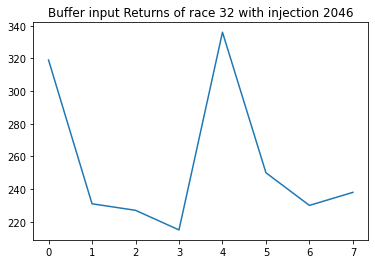

Training starts...
Buufer size: 66588, Starting race 32


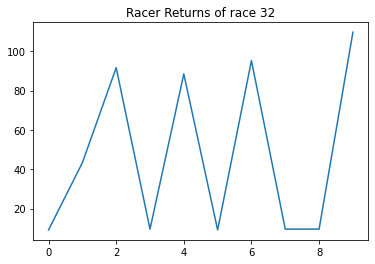

Race complete!
At race 32, finalist model is Model#(9) with episode reward 109.6
carrying following Model numbers: [6, 9]
Starting filling buffer: 33...


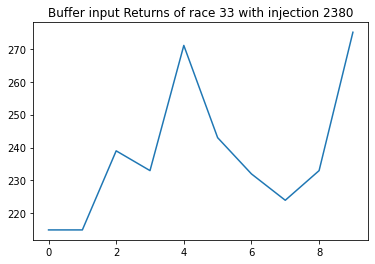

Training starts...
Buufer size: 68968, Starting race 33


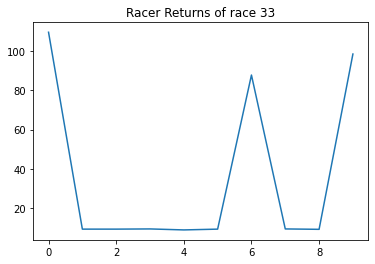

Race complete!
At race 33, finalist model is Model#(0) with episode reward 109.6
carrying following Model numbers: [0, 9]
Starting filling buffer: 34...


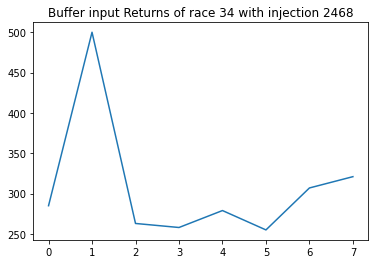

Training starts...
Buufer size: 71436, Starting race 34


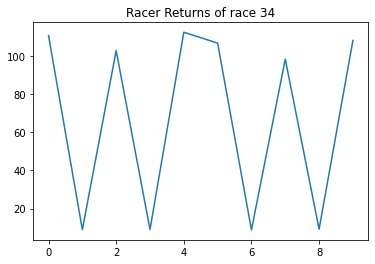

Race complete!
At race 34, finalist model is Model#(4) with episode reward 112.4
carrying following Model numbers: [0, 4]
Starting filling buffer: 35...


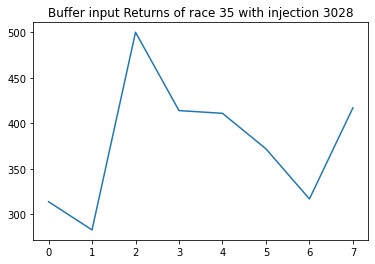

Training starts...
Buufer size: 74464, Starting race 35


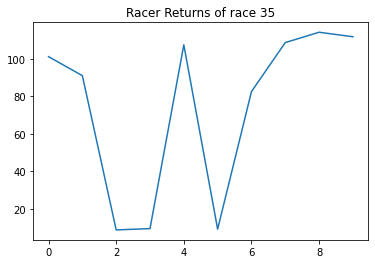

Race complete!
At race 35, finalist model is Model#(8) with episode reward 114.1
carrying following Model numbers: [8, 9]
Starting filling buffer: 36...


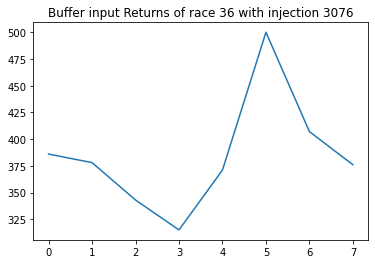

Training starts...
Buufer size: 77540, Starting race 36


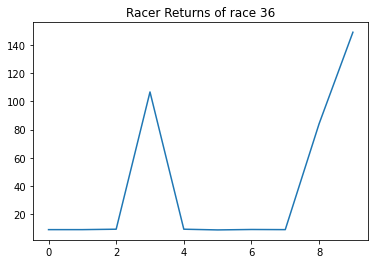

Race complete!
At race 36, finalist model is Model#(9) with episode reward 148.8
carrying following Model numbers: [9]
Starting filling buffer: 37...


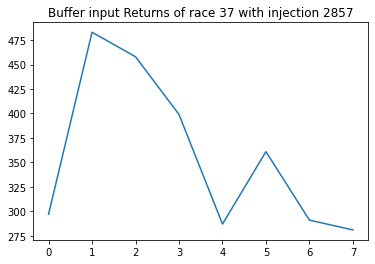

Training starts...
Buufer size: 80397, Starting race 37


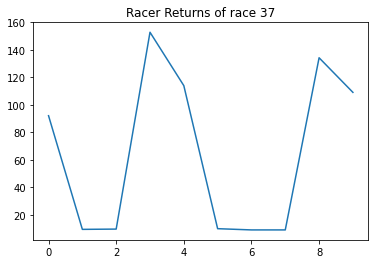

Race complete!
At race 37, finalist model is Model#(3) with episode reward 152.9
carrying following Model numbers: [3, 8]
Starting filling buffer: 38...


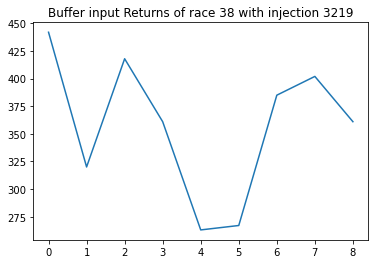

Training starts...
Buufer size: 83616, Starting race 38


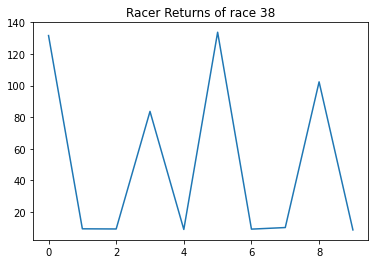

Race complete!
At race 38, finalist model is Model#(5) with episode reward 133.8
carrying following Model numbers: [0, 5]
Starting filling buffer: 39...


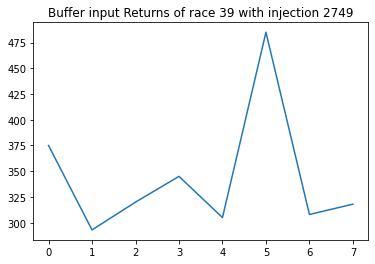

Training starts...
Buufer size: 86365, Starting race 39


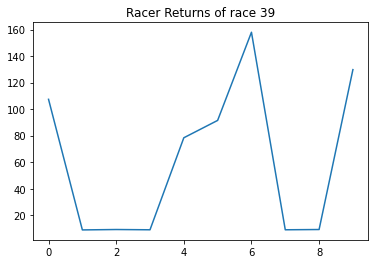

Race complete!
At race 39, finalist model is Model#(6) with episode reward 158.0
carrying following Model numbers: [6, 9]
Starting filling buffer: 40...


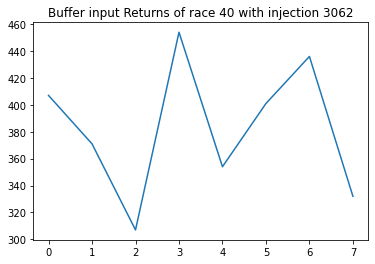

Training starts...
Buufer size: 89427, Starting race 40


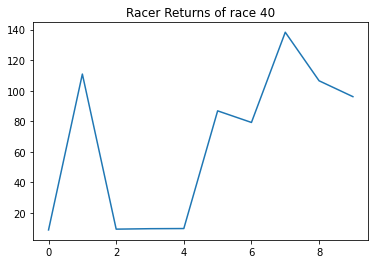

Race complete!
At race 40, finalist model is Model#(7) with episode reward 138.3
carrying following Model numbers: [7]
Starting filling buffer: 41...


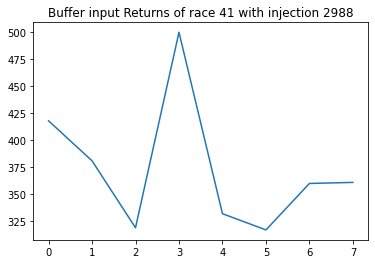

Training starts...
Buufer size: 92415, Starting race 41


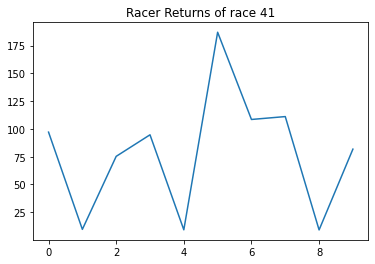

Race complete!
At race 41, finalist model is Model#(5) with episode reward 187.0
carrying following Model numbers: [5]
Starting filling buffer: 42...


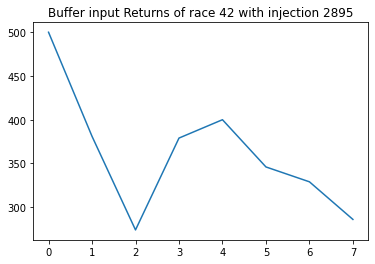

Training starts...
Buufer size: 95310, Starting race 42


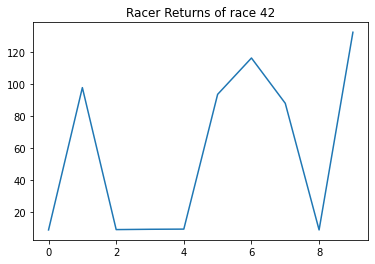

Race complete!
At race 42, finalist model is Model#(9) with episode reward 132.5
carrying following Model numbers: [6, 9]
Starting filling buffer: 43...


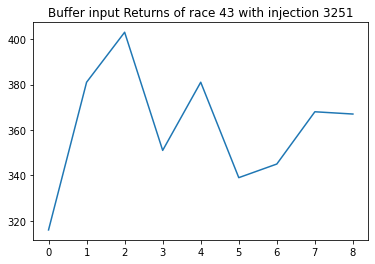

Training starts...
Buufer size: 98561, Starting race 43


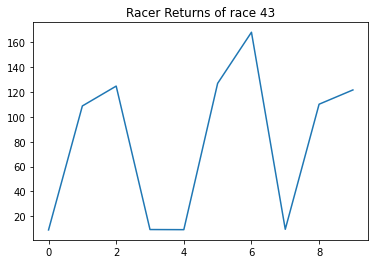

Race complete!
At race 43, finalist model is Model#(6) with episode reward 168.2
carrying following Model numbers: [6]
Starting filling buffer: 44...


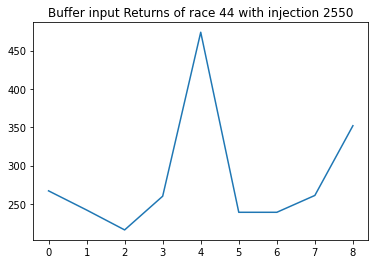

Training starts...
Buufer size: 101111, Starting race 44


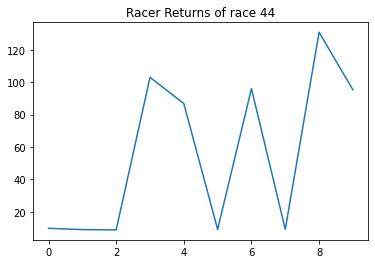

Race complete!
At race 44, finalist model is Model#(8) with episode reward 130.8
carrying following Model numbers: [8]
Starting filling buffer: 45...


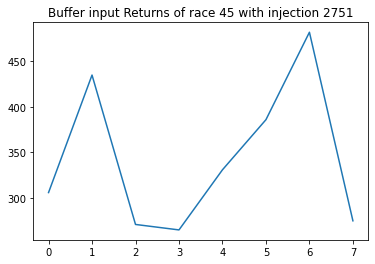

Training starts...
Buufer size: 103862, Starting race 45


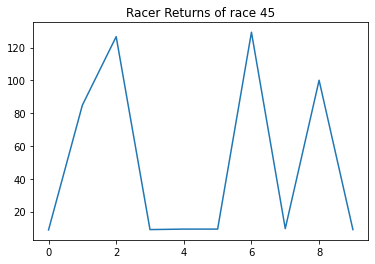

Race complete!
At race 45, finalist model is Model#(6) with episode reward 129.4
carrying following Model numbers: [2, 6]
Starting filling buffer: 46...


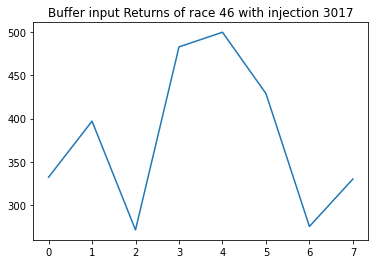

Training starts...
Buufer size: 106879, Starting race 46


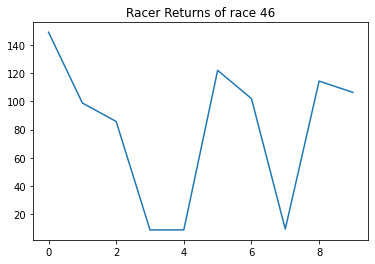

Race complete!
At race 46, finalist model is Model#(0) with episode reward 148.9
carrying following Model numbers: [0, 5]
Starting filling buffer: 47...


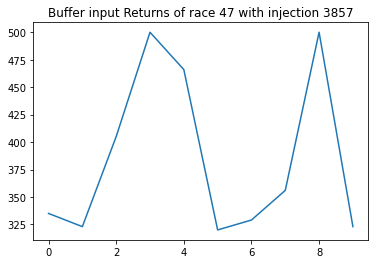

Training starts...
Buufer size: 110736, Starting race 47


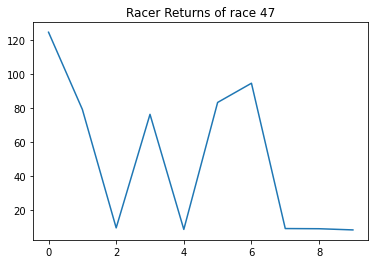

Race complete!
At race 47, finalist model is Model#(0) with episode reward 124.7
carrying following Model numbers: [0]
Starting filling buffer: 48...


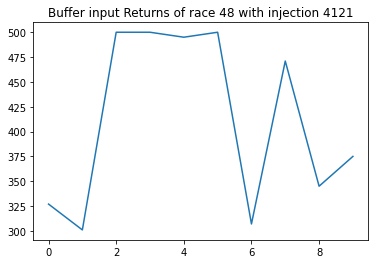

Training starts...
Buufer size: 114857, Starting race 48


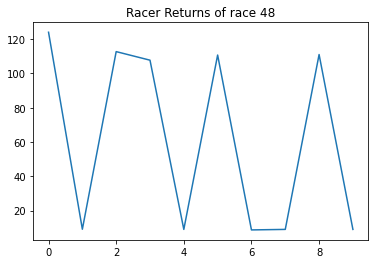

Race complete!
At race 48, finalist model is Model#(0) with episode reward 124.0
carrying following Model numbers: [0, 2]
Starting filling buffer: 49...


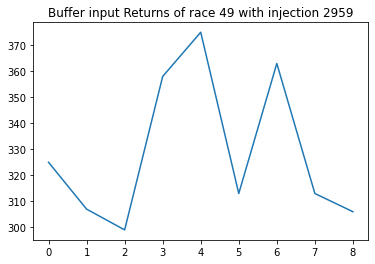

Training starts...
Buufer size: 117816, Starting race 49


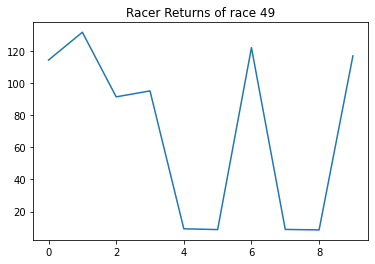

Race complete!
At race 49, finalist model is Model#(1) with episode reward 131.6
carrying following Model numbers: [1, 6]
Starting filling buffer: 50...


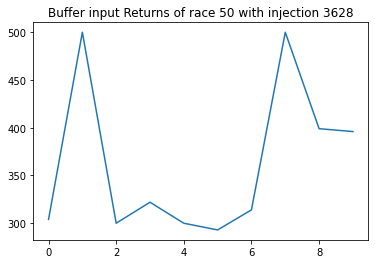

Training starts...
Buufer size: 121444, Starting race 50


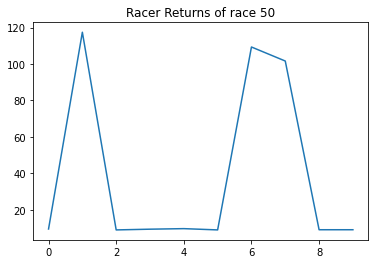

Race complete!
At race 50, finalist model is Model#(1) with episode reward 117.4
carrying following Model numbers: [1, 6]
Starting filling buffer: 51...


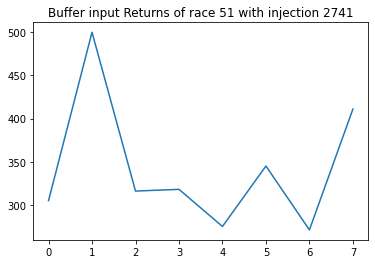

Training starts...
Buufer size: 124185, Starting race 51


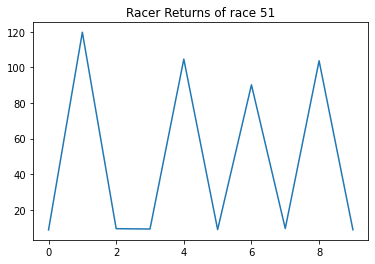

Race complete!
At race 51, finalist model is Model#(1) with episode reward 119.7
carrying following Model numbers: [1, 4]
Starting filling buffer: 52...


In [9]:
a = Agent("CartPole-v1")
print(f"Starts at {datetime.now().strftime('%y-%m-%d, %H:%M:%S')}")
a.train()
print(f"Ends at {datetime.now().strftime('%y-%m-%d, %H:%M:%S')}")